<a href="https://colab.research.google.com/github/AndrewBoessen/CSCI3387_Notebooks/blob/main/TrainVQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _Dependencies_

In [1]:
!pip install umap-learn
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.4 MB/s eta 0:00:00


# _Imports_

In [2]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
from six.moves import xrange
import umap.umap_ as umap
from collections import deque
import random

import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython import display
from IPython.display import HTML
from base64 import b64encode

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import numpy
import numpy as np

# Specify the path to your .npy file in Google Drive
file_path = '/content/drive/My Drive/CSCI3387 Project/skiing_observations (1).npy'

# Load the numpy file
data = np.load(file_path)

data = data.astype(np.float32) / 255.0

# Print the loaded data
print(data.shape)

Mounted at /content/drive
(1010, 256, 256, 3)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
# Assuming your data is in the shape (n_samples, ...)
training_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", training_data.shape)
print("Validation data shape:", validation_data.shape)


Training data shape: (808, 256, 256, 3)
Validation data shape: (202, 256, 256, 3)


In [5]:
data_variance = np.var(training_data / 255.0)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# __VQ-VAE Implementation__

The pytorch implementation for the VQ-VAE network is given below

In [7]:
class VectorQuantizerEMA(nn.Module):
    '''
    Implements Exponential Moving Average (EMA) vector quantization for VQ-VAE models.
    '''
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim # Dimension of the embedding, D
        self._num_embeddings = num_embeddings # Number of categories in distribution, K

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # Embedding table
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost # Constant used in loss function

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [8]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._conv2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._conv3 = nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv1(inputs)
        x = F.relu(x)
        x = self._conv2(x)
        x = F.relu(x)
        x = self._conv3(x)
        return self._residual_stack(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens,
                                kernel_size=3, stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens // 2,
                                                kernel_size=4, stride=2, padding=1)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens // 2,
                                                out_channels=3,
                                                kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv1(inputs)
        x = self._residual_stack(x)
        x = self._conv_trans_1(x)
        x = F.relu(x)
        return self._conv_trans_2(x)

In [11]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay):
        super(VQVAE, self).__init__()

        self._encoder = Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim,
                                      kernel_size=1, stride=1)

        self._vq = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        self._decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x) # encode image to latent
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq(z) # quantize encoding to dicrete space
        x_recon = self._decoder(quantized) # reconstruction of input from decoder
        return loss, x_recon, perplexity

# __Train__

We use the hyperparameters from the author's code:

In [27]:
batch_size = 128
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [13]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [14]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [15]:
model = VQVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [28]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

train_observations = []
train_recon_observations = []

for i in xrange(num_training_updates):
    data = next(iter(training_loader))
    data = data.to(device)
    data = data.permute(0, 3, 1, 2).contiguous()
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        train_recon_observations.append(data_recon[0].permute(1, 2, 0).detach().cpu().numpy())
        train_observations.append(data[0].permute(1, 2, 0).detach().cpu().numpy())
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 23493.458
perplexity: 2.773

200 iterations
recon_error: 19420.177
perplexity: 2.786

300 iterations
recon_error: 16614.033
perplexity: 3.101

400 iterations
recon_error: 14524.379
perplexity: 3.303

500 iterations
recon_error: 12756.430
perplexity: 3.273

600 iterations
recon_error: 11409.037
perplexity: 3.182



KeyboardInterrupt: 

## Training Vizualization

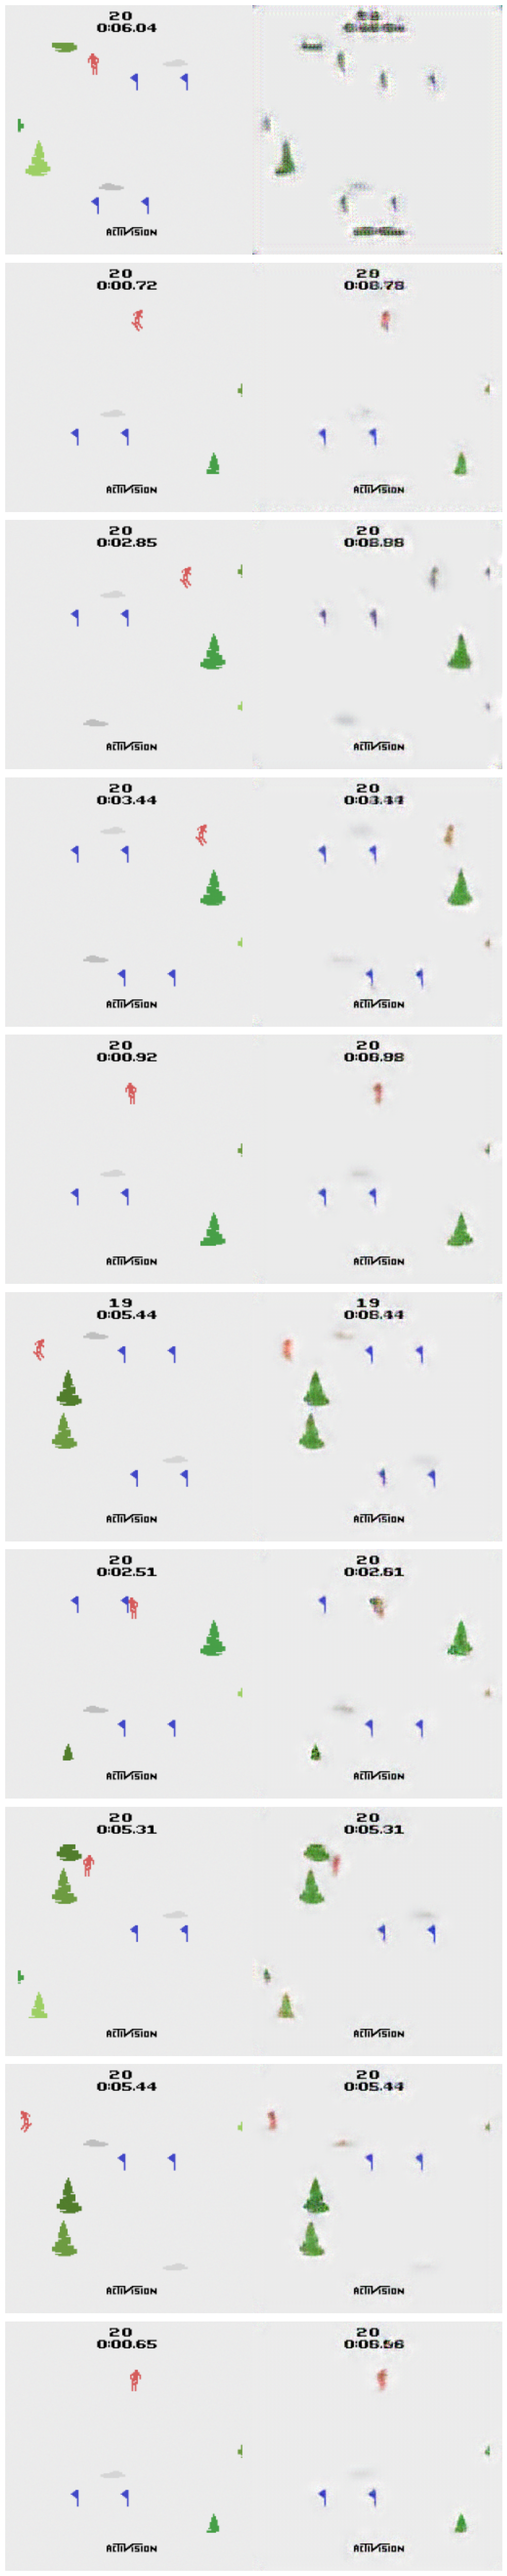

In [18]:
train_observations = np.array(train_observations)
train_recon_observations = np.array(train_recon_observations)

# Plot side by side comparrison in grid

def plot_image_pairs(array1, array2):
  """Randomly selects and plots 10 pairs of images from two arrays.

  Args:
    array1: The first array of images.
    array2: The second array of images.
  """

  num_pairs = 10
  indices = random.sample(range(len(array1)), num_pairs)

  indicies =  indices.sort()

  fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))

  for i, index in enumerate(indices):
    axes[i, 0].imshow(array1[index])
    axes[i, 0].axis('off')
    axes[i, 1].imshow(array2[index])
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

# Assuming 'train_observations' and 'train_recon_observations' are your arrays
plot_image_pairs(train_observations, train_recon_observations)

## Plot Loss

In [19]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

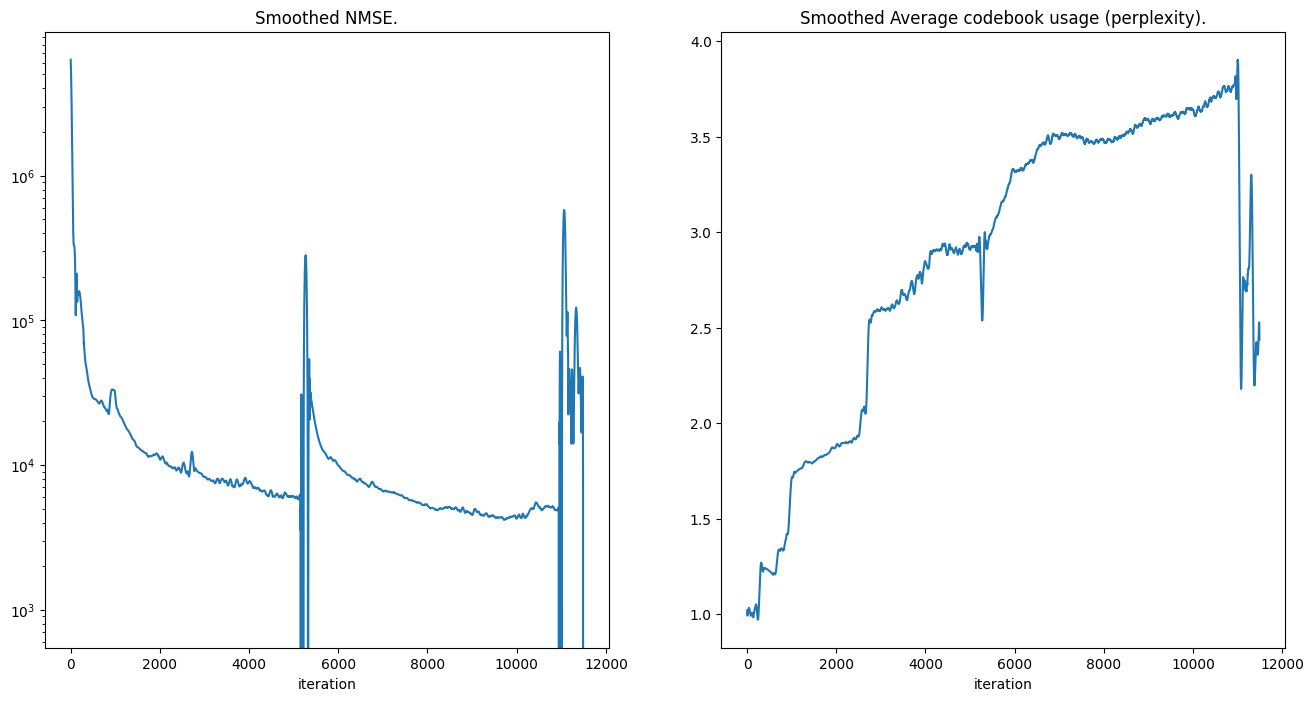

In [20]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [21]:
model.eval()

valid_originals = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

valid_originals = valid_originals.permute(0, 3, 1, 2).contiguous()

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [22]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

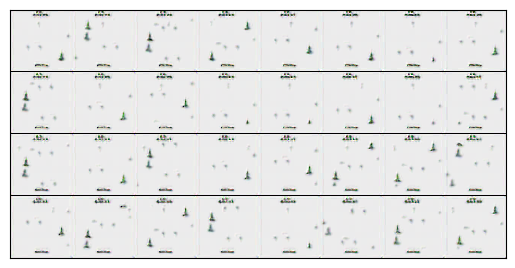

In [23]:
show(make_grid((valid_reconstructions.cpu().data)))

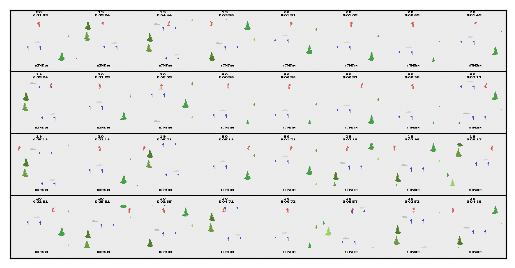

In [24]:
show(make_grid((valid_originals.cpu())))

## View Embedding

In [25]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq._embedding.weight.data.cpu())

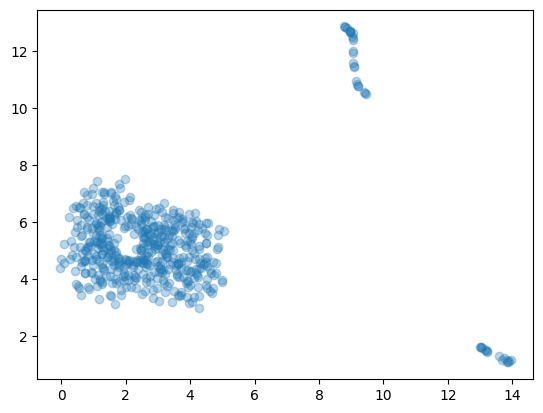

In [26]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)